Working on the notebook to be able to visualy test the results

In [11]:
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the similarities data
similarities_path = 'C:/Users/Anastasia/Desktop/greek-parliament-proceedings-analysis/spark-analysis/src/main/scala/auth/dws/bigdata/results/task4_sim_50'
sims_df = pd.read_parquet(similarities_path)

In [16]:
def same_party_sim(similarities_df, party_name):
    """Retern a dataframe that contains only same party similarity values for consequtive quarters
    """
    # extract a list of sitting quarters values
    quarters_list = similarities_df.sort_values(['sitting_quarter_a'])['sitting_quarter_a'].unique().tolist()

    # generate a list of consequtive quarters and generate a dataframe with the consuqutive quarter values
    consequtive_q_list = ["-".join(quarters_list[idx : idx + 2]) for idx in range(len(quarters_list)-2+1)]
    quarters_df = pd.DataFrame({'sitting_quarter_a': quarters_list[:-1], 'cons_q': consequtive_q_list})


    # retain only the same-party similarities
    sims_of_interest_df = similarities_df\
        .loc[similarities_df['political_party_a']==similarities_df['political_party_b'], :]\
        .loc[similarities_df['political_party_a']==party_name, :]

    #  add a new column the represents the quarter pair for which the similarity is calculated
    sims_of_interest_df['q_after'] = sims_of_interest_df['sitting_quarter_a'] + '-' + sims_of_interest_df['sitting_quarter_b']

    # join the the similarities dataframe with the consequtive quarters and keep only the consequtive quarters
    sims_of_interest_df = pd.merge(sims_of_interest_df, quarters_df, on='sitting_quarter_a')
    sims_of_interest_df = sims_of_interest_df\
        .loc[sims_of_interest_df['q_after']==sims_of_interest_df['cons_q'], :]\
        .drop(columns=['q_after', 'cons_q'])\
        .reset_index(drop=True)\
        .sort_values('sitting_quarter_a')

    return sims_of_interest_df


def construct_t_test(similarities_df, q_threshold="2008 Q4"):
    """return the test value of a paired t-test on similarities
    """

    # generate similarities list before and after the threshold
    sim_bef = similarities_df[similarities_df['sitting_quarter_a']<q_threshold]['sim'].tolist()
    sim_after = similarities_df[similarities_df['sitting_quarter_a']>=q_threshold]['sim'].tolist()

    # if the length of the lists is not the same, use random sampling to select same-length lists
    m = min(len(sim_bef), len(sim_after))
    if len(sim_bef) > m:
        sim_bef = random.sample(sim_bef, m)
    if len(sim_after) > m:
        sim_after = random.sample(sim_after, m)

    # print(np.mean(sim_bef), np.std(sim_bef))
    # print(np.mean(sim_after), np.std(sim_after))
    
    res = stats.ttest_rel(sim_bef, sim_after)

    return res.pvalue




In [17]:
# select the columns to keep and remove "εξωκοινοβουλευτικός"
sims_df = sims_df\
    .loc[:, ['political_party_a', 'sitting_quarter_a', 'political_party_b', 'sitting_quarter_b', 'sim']]\
    .loc[(sims_df['political_party_a']!='εξωκοινοβουλευτικός') & (sims_df['political_party_b']!='εξωκοινοβουλευτικός'), :]


for selected_party in sims_df['political_party_a'].unique():

    sims_of_int_df = same_party_sim(sims_df, selected_party)
    
    test_prob = construct_t_test(sims_of_int_df)

    # if res.pvalue < 0.05:
    print(selected_party, test_prob)



λαικος ορθοδοξος συναγερμος 0.8767167502521681
νεα δημοκρατια 0.019649380791744886
συνασπισμος της αριστερας των κινηματων και της οικολογιας nan
πανελληνιο σοσιαλιστικο κινημα 0.5823619342769757
συνασπισμος ριζοσπαστικης αριστερας 0.00020355502671414886
κομμουνιστικο κομμα ελλαδας 0.06426089353837243
ανεξαρτητοι (εκτος κομματος) 0.00014304253427278011
δημοκρατικη αριστερα nan
λαικος συνδεσμος - χρυση αυγη nan
ανεξαρτητοι ελληνες - πανος καμμενος nan


<ipython-input-18-9fe3928ec48a>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  splot.set_xticklabels(sims_of_int_df['sitting_quarter_a'], rotation = 90)


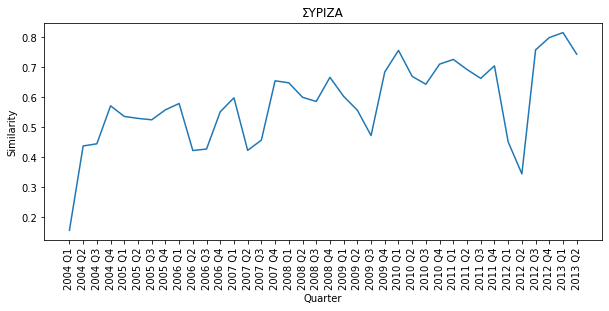

In [18]:
selected_party='συνασπισμος ριζοσπαστικης αριστερας'
sims_of_int_df = same_party_sim(sims_df, selected_party)

plt.figure(figsize=(10, 4))
splot = sns.lineplot(data=sims_of_int_df, x='sitting_quarter_a', y='sim')
splot.set_xticklabels(sims_of_int_df['sitting_quarter_a'], rotation = 90)
splot.set(xlabel='Quarter',
          ylabel='Similarity',
          title='ΣΥΡΙΖΑ')
plt.show()

In [13]:
party_a= 'νεα δημοκρατια'
party_b= 'πανελληνιο σοσιαλιστικο κινημα'

sims_of_int_df = sims_df\
    .loc[((sims_df['political_party_a']==party_a) & (sims_df['political_party_b']==party_b)), :]

sims_of_int_df = sims_of_int_df\
    .loc[sims_of_int_df['sitting_quarter_a']==sims_of_int_df['sitting_quarter_b'], :]\
    .sort_values('sitting_quarter_a')


sim_bef = sims_of_int_df[sims_of_int_df['sitting_quarter_a']<'2008 Q4']['sim'].tolist()
sim_after = sims_of_int_df[sims_of_int_df['sitting_quarter_a']>='2008 Q4']['sim'].tolist()
m = min(len(sim_bef), len(sim_after))
if len(sim_bef) > m:
    sim_bef = random.sample(sim_bef, m)
if len(sim_after) > m:
    sim_after = random.sample(sim_after, m)

res = stats.ttest_rel(sim_bef, sim_after)

# if res.pvalue < 0.05:
print(res.pvalue)

0.05967825769446381


<ipython-input-19-4cabdbef3269>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  splot.set_xticklabels(sims_of_int_df['sitting_quarter_a'], rotation = 90)


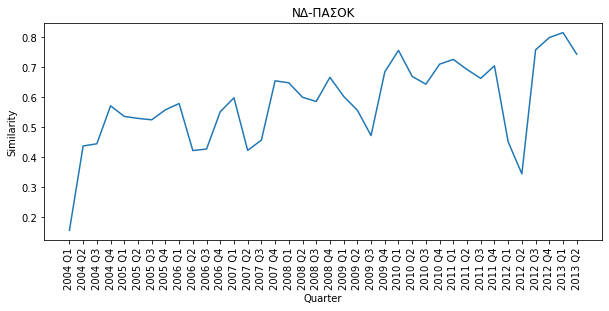

nan nan
nan nan


C:\Users\Anastasia\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Anastasia\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Anastasia\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Anastasia\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Anastasia\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_

In [19]:
plt.figure(figsize=(10, 4))
splot = sns.lineplot(data=sims_of_int_df, x='sitting_quarter_a', y='sim')
splot.set_xticklabels(sims_of_int_df['sitting_quarter_a'], rotation = 90)
splot.set(xlabel='Quarter',
          ylabel='Similarity',
          title='ΝΔ-ΠΑΣΟΚ')
plt.show()

print(np.mean(sim_bef), np.std(sim_bef))
print(np.mean(sim_after), np.std(sim_after))